In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

np.random.seed(123)

#Turn off progress printing
solvers.options['show_progress']=False

In [3]:
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *

In [4]:
import plotly
py.sign_in('linobi', 'xlupudvz62')
import cufflinks
plotly.__version__

'1.12.9'

If you wan to use real data, use the cell below:

In [5]:
from datetime import datetime
from zipline.utils.factory import load_bars_from_yahoo
end = pd.Timestamp(datetime(2016, 1, 1))
start = end - 2500* pd.tseries.offsets.BDay()

data = load_bars_from_yahoo(stocks=['IBM', 'GLD', 'XOM', 'AAPL', 
                                    'MSFT', 'TLT'],
                            start=start, end=end)

return_vec = data.loc[:, :, 'price'].pct_change().dropna()

#data.loc[:, :, 'price'].iplot(filename='prices', yTitle='price in $', world_readable=True, asDates=True)

/Users/lino/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: DeprecationWarning:

load_bars_from_yahoo is deprecated, please register a yahoo_equities data bundle instead



If you want to use artificial signals, use the cell below:

In [ ]:
## Number of assets... we'll simulate the same amount of assets used above, just for the sake of it
n_assets = 7
## Number of observations... and the same size of sample
n_obs = 2500

return_vec = np.random.randn(n_assets, n_obs)

#Put the array in dataframe form
return_vec = return_vec.T

One way or another you end up with a return_vec dataframe than includes the entire normalized vectors of daily returns of the signals used. You must chop this set of vectors incrementally in order in observe the displacement of the efficient frontier. Like this:

In [6]:
#Let's say, get the data for the first year, approximately
returns_init = return_vec[0:250].copy()  #you need to do this stupid copy, because the optimizer needs the arrays transposed, and the dynamic nature of python will attempt to transpose the chopped array into the whole one.
#and so on...
#For now we will just plot the first and the last frontiers manually:
returns_final = return_vec[-250:-1].copy()


The whole point of the code below is to generate a set of random portfolios. It may be useful for visualization purposes, and check that the efficient frontier gets calculated correctly.

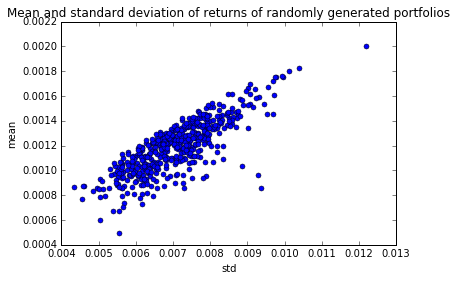

In [7]:
def rand_weights(n):
    '''Produces n random weights that sum to 1, can comein handy'''
    k = np.random.rand(n)
    return k / sum(k)

def random_portfolio(returns):
    '''
    Returns the mean and the standard deviation of returns for a random portfolio
    '''
    
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    #This recursion reduces ouliers to keep plots pretty
    #if sigma > 2:
    #    return random_portfolio(returns)
    return mu, sigma

n_portfolios = 500
means, stds = np.column_stack([
        random_portfolio(returns_init.T) #Notice the transposed array
        for _ in range(n_portfolios)
    ])

#just plotting stuff...
fig = plt.figure()
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')
plt.show()
#py.iplot_mpl(fig, file_name='mean_std2', strip_style=True)

A now, the infamous Markowitz Cone optimization technique:

In [8]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0*t/N - 1.0) for t in range(N)]
    
    #Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    #Create constraint matrices
    G = -opt.matrix(np.eye(n))
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    
    ## Calculate risks and returns for frontier
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    ## Calculate the 2nd degree polynomial of the frontier curve
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    
    ## Calculate the optimal portfolio
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

In [9]:
weigths, returns, risks = optimal_portfolio(returns_init.T) #again, note the transposed array
print(weigths)

[[  7.52082143e-08]
 [  1.65257649e-07]
 [  2.52339232e-08]
 [  9.99999504e-01]
 [  6.59079463e-08]
 [  1.64687947e-07]]


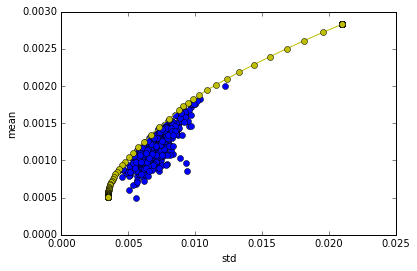

In [10]:
fig = plt.figure()
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
plt.show()
#py.iplot_mpl(fig, filename='efficient_frontier', strip_style=True)

Ok, that was for the efficient frontier at the beginning of the period being analized. Now, let's see the final frontier.

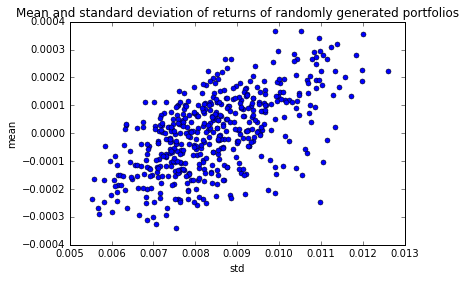

In [11]:
n_portfolios = 500
means, stds = np.column_stack([
        random_portfolio(returns_final.T)
        for _ in range(n_portfolios)
    ])

#just plotting stuff...
fig = plt.figure()
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')
plt.show()
#py.iplot_mpl(fig, file_name='final', strip_style=True)

In [22]:
#try:
weigths, returns, risks = optimal_portfolio(returns_final.T)
#except ValueError as e:
    # Sometimes this error is thrown
    # ValueError: Rank(A) < p or Rank([P; A; G]) < n
    # That is because the classical optimzer doesn't like assets with very constant returns
    # I don't know the mathematical or implementation reason for that. But it shouldn't be.
#    pass

fig = plt.figure()
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
#plt.show()
py.iplot_mpl(fig, filename='efficient_frontier_final', strip_style=True)

/Users/lino/anaconda/lib/python3.5/site-packages/plotly/matplotlylib/renderer.py:516: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



Ok, that was fun. Now let's see if we can plot the surface of the dynamic frontier

In [25]:
print(std)
print(mean)

[[ 0.01783189]]
[[ 0.00104874]]


In [15]:
def portfolio_performance(returns, weights):
    '''
    Returns the mean and the standard deviation of returns for a given portfolio (given a set of time series)
    '''
    
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(weights)
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    return mu, sigma

In [18]:
mean, std = portfolio_performance(returns_final.T, weigths.T)

In [23]:
print(std)

[[ 0.01783189]]


In [ ]:
def initialize(context):
    '''
    Called once at the very beginning of a backtest (and live trading). 
    Use this method to set up any bookkeeping variables.
    
    The context object is passed to all the other methods in your algorithm.

    Parameters

    context: An initialized and empty Python dictionary that has been 
             augmented so that properties can be accessed using dot 
             notation as well as the traditional bracket notation.
    
    Returns None
    '''
    context.tick = 0

In [ ]:
def handle_data(context, data):
    '''
    Called when a market event occurs for any of the algorithm's 
    securities. 

    Parameters

    data: A dictionary keyed by security id containing the current 
          state of the securities in the algo's universe.

    context: The same context object from the initialize function.
             Stores the up to date portfolio as well as any state 
             variables defined.

    Returns None
    '''
    # Allow history to accumulate 100 days of prices before trading
    # and rebalance every day thereafter.
    context.tick += 1
    if context.tick < 100:
        return
    # Get rolling window of past prices and compute returns
    
    #rebalance only every i days
    i = 5
    if (context.tick % i) != 0:
        return
    
    prices = history(100, '1d', 'price').dropna()
    returns = prices.pct_change().dropna()
    try:
        # Perform Markowitz-style portfolio optimization
        weights, _, _ = optimal_portfolio(returns.T)
        weights = np.around(weights)
        # Rebalance portfolio accordingly
        for stock, weight in zip(prices.columns, weights):
            order_target_percent(stock, weight)
    except ValueError as e:
        # Sometimes this error is thrown
        # ValueError: Rank(A) < p or Rank([P; A; G]) < n
        pass


In [ ]:
# Instantinate algorithm        
algo = TradingAlgorithm(initialize=initialize, 
                        handle_data=handle_data)

In [ ]:
# Run algorithm
results = algo.run(data)

In [ ]:
results.portfolio_value.iplot(filename='algo_perf', yTitle='Cumulative capital in $', world_readable=True, asDates=True)

In [ ]:
results.portfolio_value.iplot(filename='algo_perf20', yTitle='Cumulative capital in $', world_readable=True, asDates=True)

In [ ]:
results.portfolio_value.iplot(filename='algo_perf60', yTitle='Cumulative capital in $', world_readable=True, asDates=True)

In [ ]:
results.portfolio_value.iplot(filename='algo_perf5', yTitle='Cumulative capital in $', world_readable=True, asDates=True)

In [ ]:
results